In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tyssue.generation import generate_ring
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec

from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.segmentation.segment2D import normalize_scale
from tyssue_taylor.models.display import (print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference, create_organo)
from tyssue_taylor.adjusters.adjust_annular import prepare_tensions, adjust_parameters
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.adjusters.force_inference import infer_forces, opt_sum_lambda

Using TensorFlow backend.


In [2]:
def spread_distrib(array, factor):
    m = np.mean(array)
    ecart_moyenne = array - np.full(array.shape, m)
    new_array = array + factor*ecart_moyenne
    return new_array

Reseting datasets values with new specs
Reseting datasets values with new specs


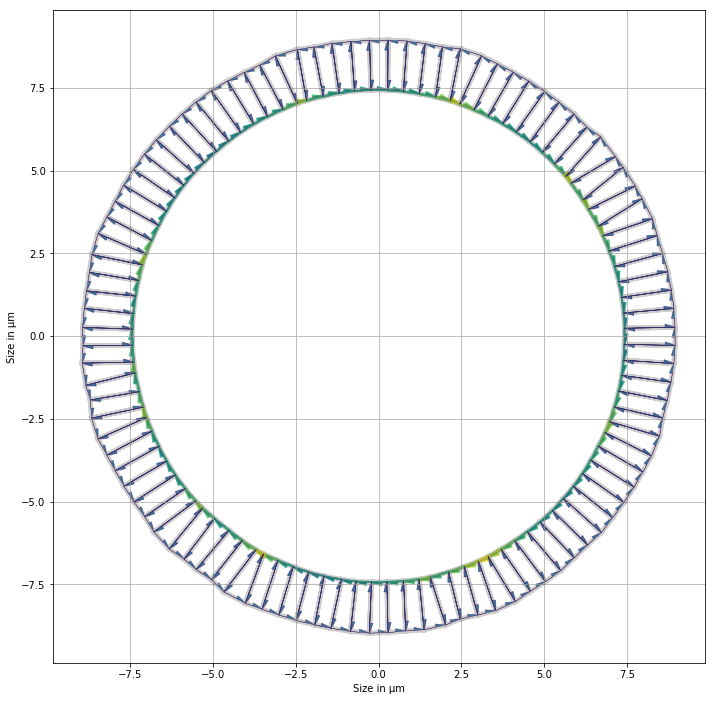

In [3]:
nf, r_in, r_out = (100, 1, 1.2)
seed = 1
organo = create_organo(nf, r_in, r_out)
lat_tens = np.array([
    0.031, 0.033, 0.037, 0.039, 0.040,
    0.036, 0.036, 0.032, 0.032, 0.034,
    0.035, 0.031, 0.038, 0.038, 0.034,
    0.035, 0.036, 0.037, 0.038, 0.039,
    0.040, 0.038, 0.04, 0.036, 0.033,
    0.032, 0.035, 0.036, 0.035, 0.034,
    0.033, 0.032, 0.039, 0.037, 0.038,
    0.03, 0.031, 0.032, 0.035, 0.037,
    0.036, 0.034, 0.032, 0.031, 0.03,
    0.032, 0.035, 0.036, 0.037, 0.038,
    0.039, 0.040, 0.041, 0.042, 0.043,
    0.041, 0.039, 0.038, 0.036, 0.035,
    0.034, 0.033, 0.032, 0.03, 0.031,
    0.032, 0.035, 0.036, 0.037, 0.038,
    0.039, 0.037, 0.038, 0.04, 0.038,
    0.037, 0.035, 0.034, 0.035, 0.033,
    0.032, 0.03, 0.031, 0.033, 0.034,
    0.036, 0.035, 0.037, 0.035, 0.035,
    0.031, 0.033, 0.034, 0.036, 0.037,
    0.040, 0.038, 0.036, 0.034, 0.033,
])

specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  np.array([
    0.09, 0.085, 0.09, 0.095, 0.095,
    0.10, 0.095, 0.09, 0.095, 0.095,
    0.10, 0.105, 0.10, 0.105, 0.11,
    0.105, 0.10, 0.095, 0.09, 0.095,
    0.09, 0.085, 0.09, 0.095, 0.095,
    0.10, 0.095, 0.09, 0.095, 0.095,
    0.10, 0.105, 0.10, 0.105, 0.11,
    0.105, 0.10, 0.095, 0.09, 0.095,
    0.09, 0.085, 0.09, 0.095, 0.095,
    0.10, 0.095, 0.09, 0.095, 0.095,
    0.10, 0.105, 0.10, 0.105, 0.11,
    0.105, 0.10, 0.095, 0.09, 0.095,
    0.09, 0.085, 0.09, 0.095, 0.095,
    0.10, 0.095, 0.09, 0.095, 0.095,
    0.10, 0.105, 0.10, 0.105, 0.11,
    0.105, 0.10, 0.095, 0.09, 0.095,
    0.09, 0.085, 0.09, 0.095, 0.095,
    0.10, 0.095, 0.09, 0.095, 0.095,
    0.10, 0.105, 0.10, 0.105, 0.11,
    0.105, 0.10, 0.095, 0.09, 0.095
]) + organo.face_df.area, 
        'area_elasticity': 1,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': np.concatenate((spread_distrib(np.array([
                                        0.101, 0.105, 0.108, 0.112, 0.119,
                                        0.127, 0.119, 0.112, 0.108, 0.105,
                                        0.102, 0.101, 0.103, 0.108, 0.114,
                                        0.121, 0.130, 0.140, 0.130, 0.121,
                                        0.114, 0.125, 0.116, 0.109, 0.107,
                                        0.105, 0.103, 0.101, 0.099, 0.102,
                                        0.109, 0.120, 0.137, 0.121, 0.113,
                                        0.107, 0.115, 0.127, 0.116, 0.109,
                                        0.106, 0.105, 0.109, 0.118, 0.127,
                                        0.118, 0.111, 0.122, 0.111, 0.108,
                                        0.107, 0.105, 0.112, 0.119, 0.130,
                                        0.121, 0.111, 0.106, 0.103, 0.102,
                                        0.100, 0.099, 0.096, 0.098, 0.102,
                                        0.104, 0.106, 0.108, 0.117, 0.129,
                                        0.114, 0.109, 0.106, 0.103, 0.102,
                                        0.105, 0.108, 0.114, 0.124, 0.135,
                                        0.124, 0.116, 0.109, 0.106, 0.103,
                                        0.106, 0.109, 0.116, 0.133, 0.116,
                                        0.128, 0.117, 0.128, 0.116, 0.111,
                                        0.108, 0.105, 0.103, 0.102, 0.100
                                        ]), 2) + 0.05,
                                        np.array([
                                        0.011, 0.011, 0.011, 0.01, 0.01,
                                        0.01, 0.01, 0.011, 0.011, 0.01,
                                        0.011, 0.011, 0.011, 0.011, 0.01,
                                        0.01, 0.009, 0.01, 0.01, 0.01,
                                        0.009, 0.009, 0.009, 0.01, 0.01,
                                        0.011, 0.012, 0.03, 0.012, 0.011,
                                        0.01, 0.009, 0.01, 0.01, 0.011,
                                        0.011, 0.01, 0.009, 0.01, 0.01,
                                        0.011, 0.011, 0.01, 0.01, 0.01,
                                        0.009, 0.009, 0.009, 0.01, 0.01,
                                        0.01, 0.01, 0.009, 0.01, 0.01,
                                        0.011, 0.01, 0.011, 0.01, 0.011,
                                        0.011, 0.012, 0.012, 0.011, 0.011,
                                        0.011, 0.011, 0.012, 0.013, 0.014,
                                        0.013, 0.011, 0.011, 0.012, 0.011,
                                        0.01, 0.01, 0.011, 0.01, 0.009,
                                        0.009, 0.009, 0.01, 0.011, 0.011,
                                        0.01, 0.009, 0.009, 0.008, 0.009,
                                        0.009, 0.01, 0.009, 0.01, 0.01,
                                        0.011, 0.012, 0.013, 0.012, 0.011
                                        ]),
                                        np.concatenate((lat_tens, np.roll(lat_tens, -1)))
                                       )),
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.1,
        'x_ecm': organo.vert_df.x,
        'y_ecm': organo.vert_df.y,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.05,
        'lumen_prefered_vol': organo.settings['lumen_volume'] ,
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
#normalize_scale(organo, geom)

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

## Initialisation avec la méthode d'inférence de forces

In [4]:
np.corrcoef(organo.edge_df.line_tension, organo.edge_df.length)

array([[ 1.        , -0.48318368],
       [-0.48318368,  1.        ]])

### Recherche de la valeur optimale pour la somme des tensions

In [5]:
start = time.time()
opt_cst = opt_sum_lambda(organo, method="bounded")
end = time.time() - start
print("Solving time = ", end,
      "   |   x* = ", opt_cst)

Solving time =  119.22111678123474    |   x* =  0.09448291908991673


### Application de la méthode d'inférence de force

Les tensions et les aires de préférences sont inférées. Plus précisément, les termes $A-A_0$ sont inférés.

En plus des contraintes usuelles de l'inférence de forces, on ajoute une contrainte par cellule imposant que la somme des tensions sur ses edges soit égale à une constante $C$.

Pour fixer cette constante, on utilise la formule de Farhadifar où les paramètres $\overline{\Lambda}$ et $\overline{A_0}$ sont calculé dans un organoïde symétrique (aussi appelé régulié).

Le système d'inférence de force est composé de $5N_f$ lignes et $4N_f+1$ colonnes. On le résoud avec NNLS pour garantir la non-négativité des tensions.


Distance from th org to exp org:  7.39943850966987


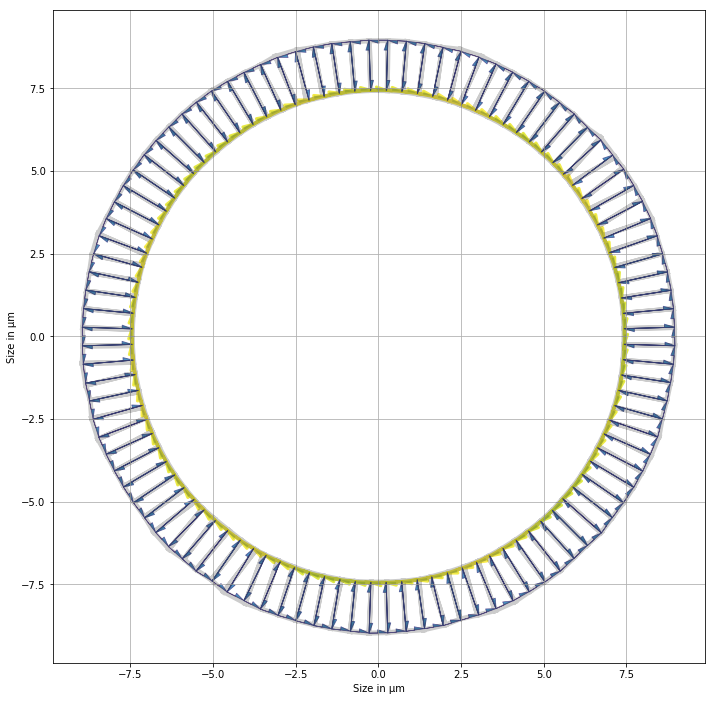

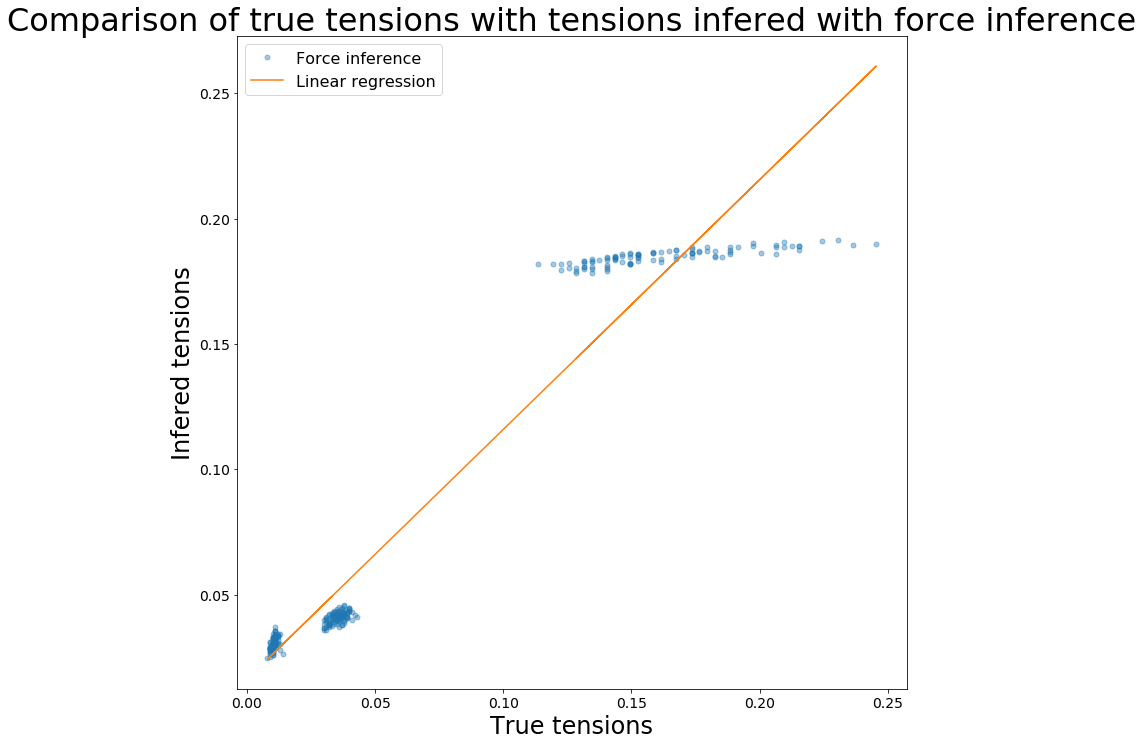

R value : 0.9694523845454984 
Standard error : 0.014970787125876999


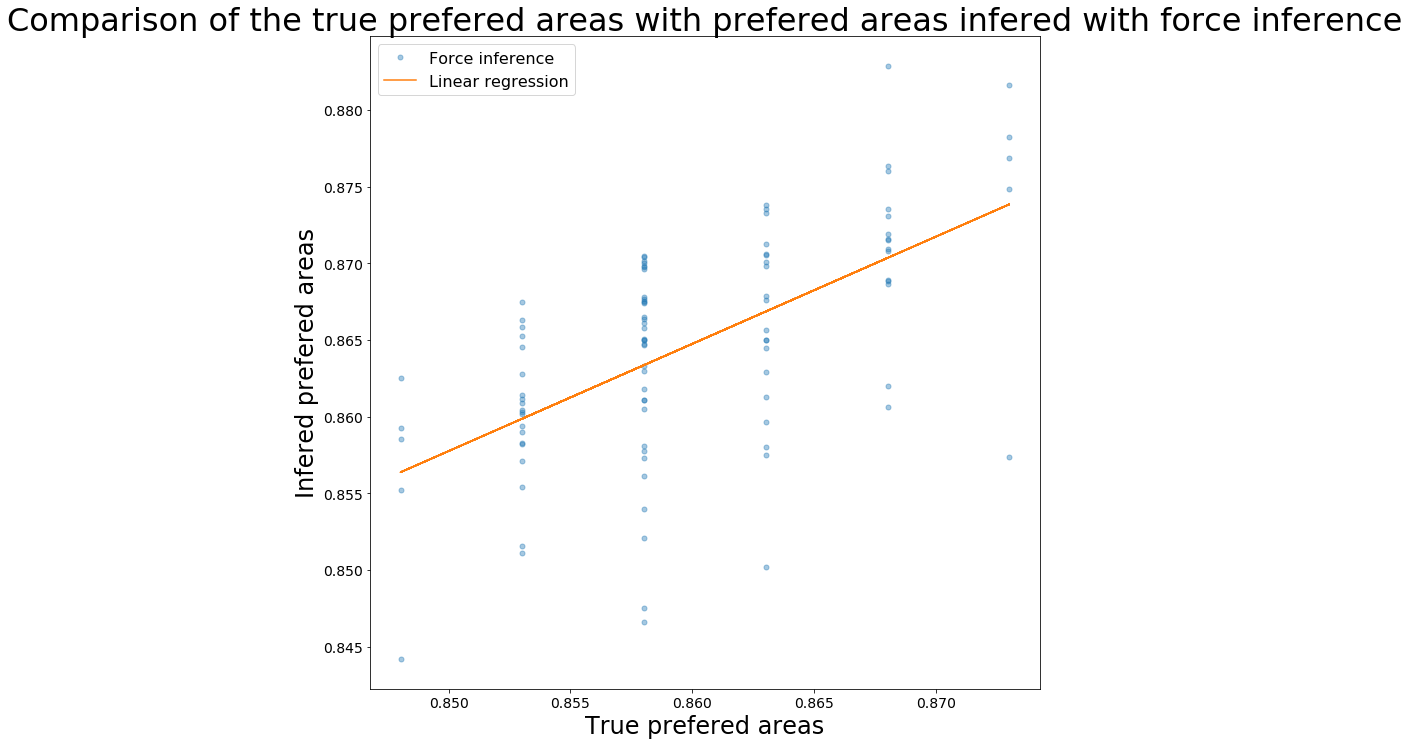

R value : 0.590692907818841 
Standard error : 0.002949323567178886


In [6]:
#Calling force inference
fi_init = infer_forces(organo, t_sum=opt_cst)
fi_t = fi_init['tensions']
fi_a = fi_init['areas']
organo_fi = organo.copy()
#Setting fi results in the mesh
organo_fi.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_fi, fi_t)
organo_fi.face_df.loc[:, 'prefered_area'] = organo_fi.face_df.area + fi_a[:-1]
organo_fi.settings['lumen_prefered_vol'] = organo_fi.settings['lumen_volume'] + fi_a[-1]
#Solving for energy min and displaying
Solver.find_energy_min(organo_fi, geom, model)
print_tensions(organo_fi, organo)
print('\nDistance from th org to exp org: ', np.sum(_distance(organo_fi, organo)))
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf], fi_t,
                  'Comparison of true tensions with tensions infered with force inference',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))
rendering_results(organo, organo.face_df.prefered_area, fi_a[:-1]+organo.face_df.area,
                  'Comparison of the true prefered areas with prefered areas infered with force inference',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

## Procédure de recalage

La résolution du problème de recalage est faite avec Levenberg-Marquardt.

In [7]:
start = time.time()
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-4, 'verbose': 0}
# Setting the initial point as the force inference result.
fi_init_array = np.r_[fi_t, organo_fi.face_df.area + fi_a[:-1],
                      organo_fi.settings['lumen_volume'] + fi_a[-1]]
rec_res = adjust_parameters(organo.copy(), fi_init_array, **lm_opt)
end = time.time() - start
print("Solving time = ", end,
      "   |   f(x*) = ", np.sum(rec_res.fun))

Solving time =  13081.109148979187    |   f(x*) =  1.2959369717399876



Distance from th org to exp org:  1.2947062009596035


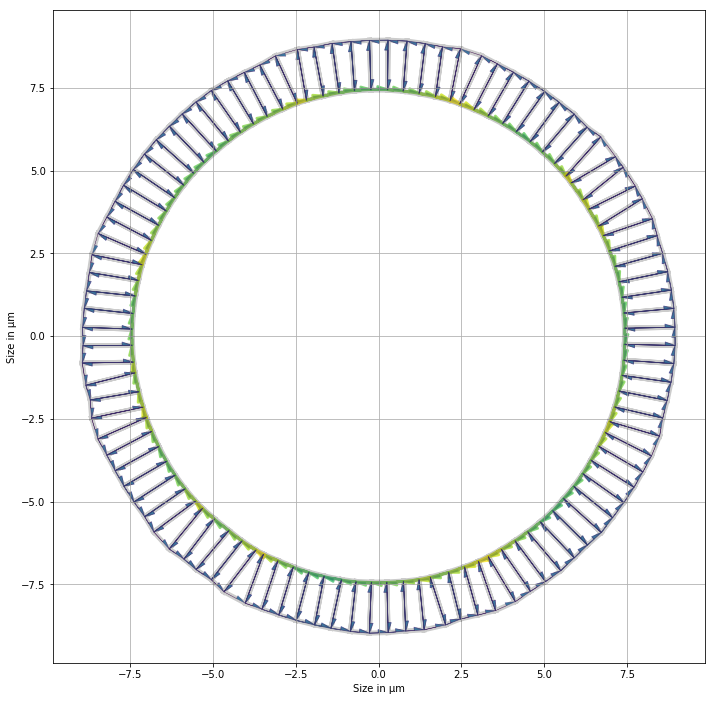

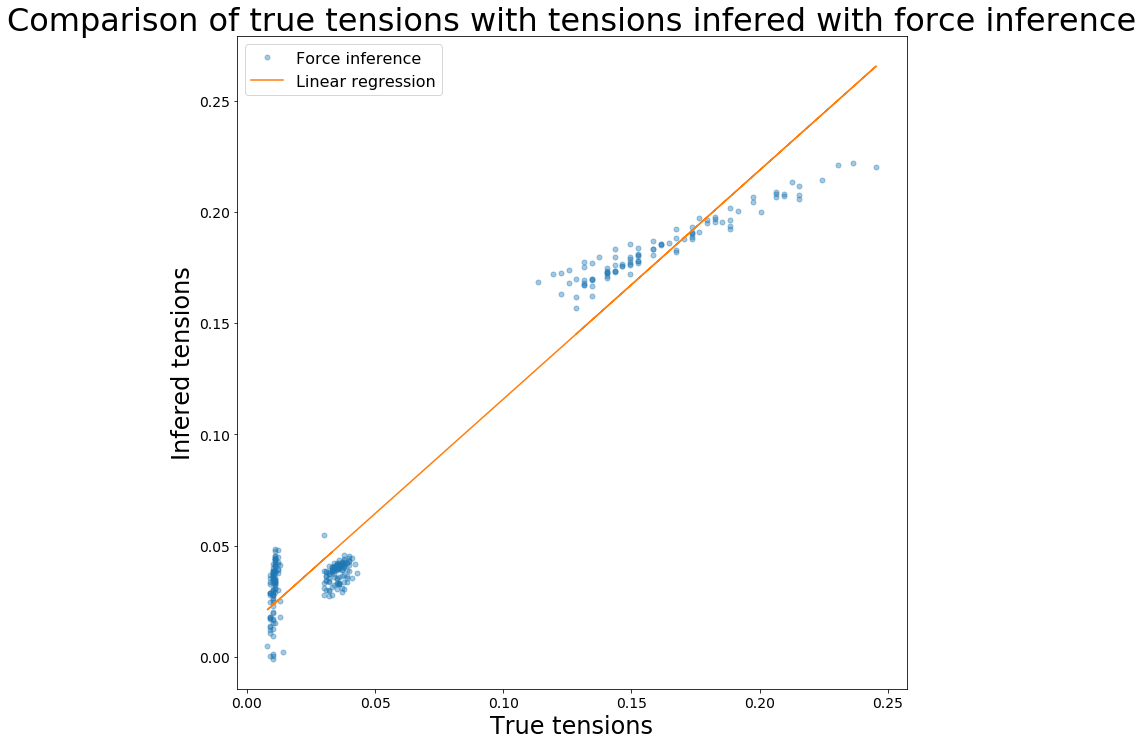

R value : 0.9797190649565131 
Standard error : 0.012507742846218679


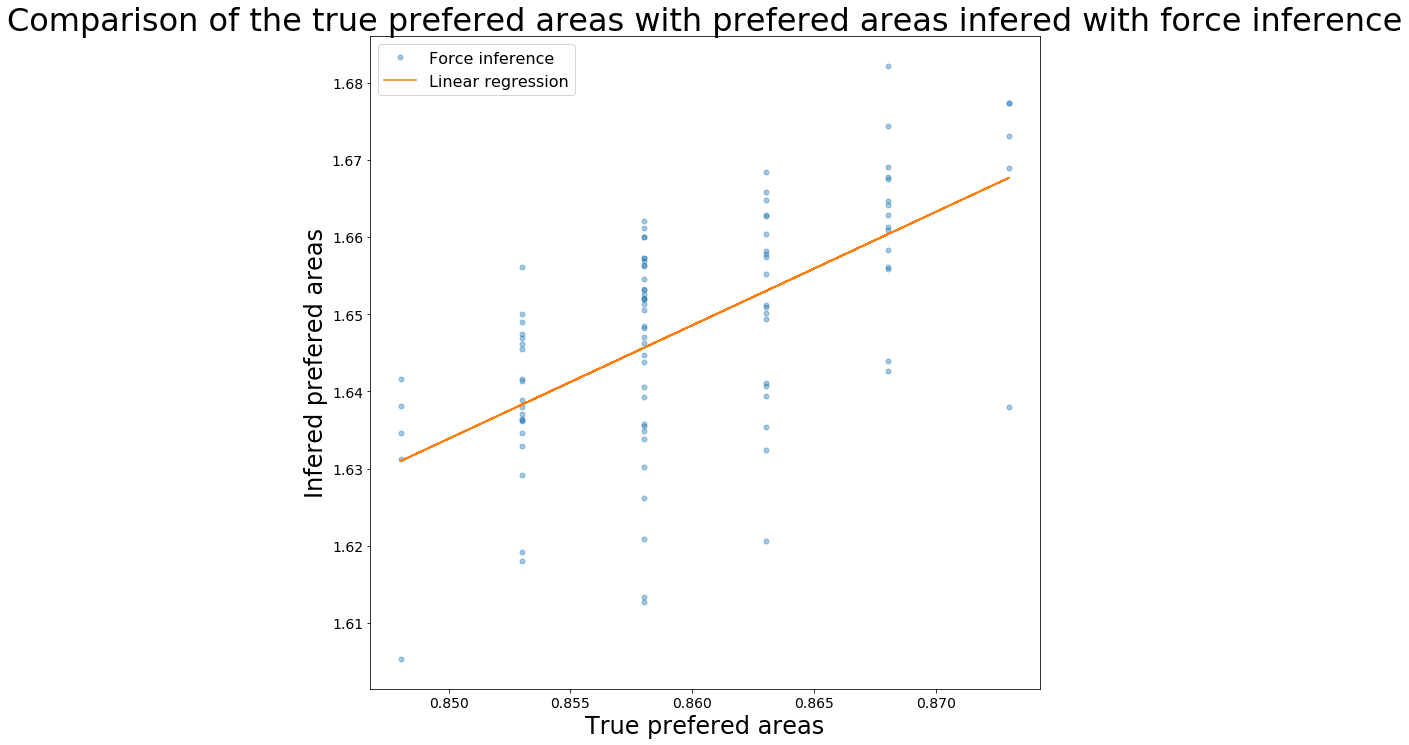

R value : 0.6051831593275734 
Standard error : 0.005973022721176481


In [8]:
rec_t = rec_res.x[:organo.Nf*3]
rec_a = rec_res.x[-(organo.Nf+1):]

organo_rec = organo.copy()
#Setting fi results in the mesh
organo_rec.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_rec, rec_t)
organo_rec.face_df.loc[:, 'prefered_area'] = rec_a[:-1]
organo_rec.settings['lumen_prefered_vol'] = rec_a[-1]
#Solving for energy min and displaying
Solver.find_energy_min(organo_rec, geom, model)
print_tensions(organo_rec, organo)
print('\nDistance from th org to exp org: ', np.sum(_distance(organo_rec, organo)))
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf], rec_t,
                  'Comparison of true tensions with tensions infered with force inference',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))
rendering_results(organo, organo.face_df.prefered_area, rec_a[:-1]+organo.face_df.area,
                  'Comparison of the true prefered areas with prefered areas infered with force inference',
                  'True prefered areas', 'Infered prefered areas', ('Force inference', 'Linear regression'))

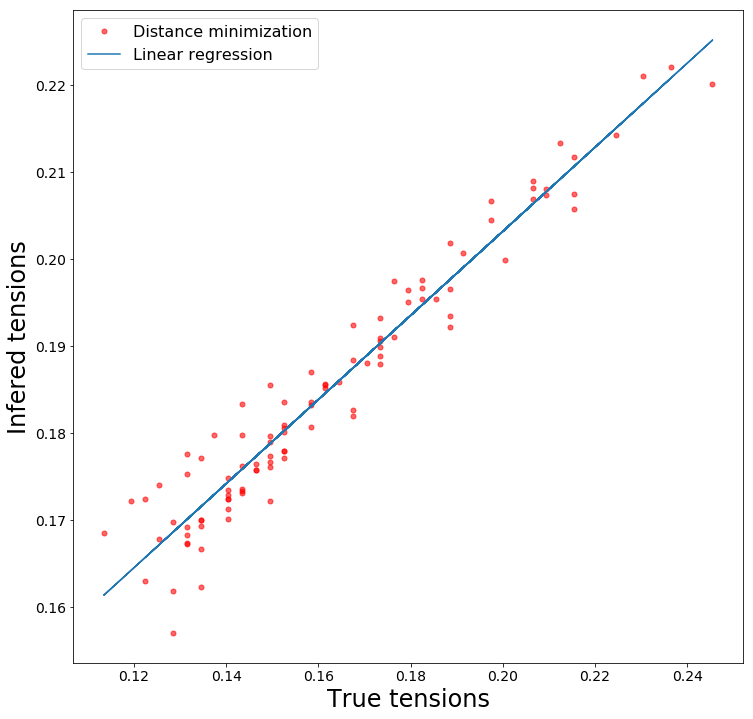

R value : 0.9679044305162217 
Standard error : 0.0018404389494998095


In [12]:
from scipy import stats
x_data = organo.edge_df.line_tension[:organo.Nf]
y_data = rec_t[:organo.Nf]
title = ''
xlabel = 'True tensions'
ylabel = 'Infered tensions'
legend = ('Distance minimization', 'Linear regression')
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data,
                                                               y_data)
fig, ax = plt.subplots()
plt.plot(x_data, y_data, 'r.', markersize=10, alpha=0.6)
plt.plot(x_data, intercept+slope*np.array(x_data), '-')
plt.title(title, fontdict={'fontsize': 32})
plt.legend(legend, loc='upper left', fontsize=16)
plt.xlabel(xlabel, fontdict={'fontsize': 24})
plt.ylabel(ylabel, fontdict={'fontsize': 24})
fig.set_size_inches(12, 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
std = np.sum(np.power(intercept+slope*np.array(x_data)-y_data, 2))
print('R value :', r_value,
      '\nStandard error :', (std/organo.Ne)**0.5)

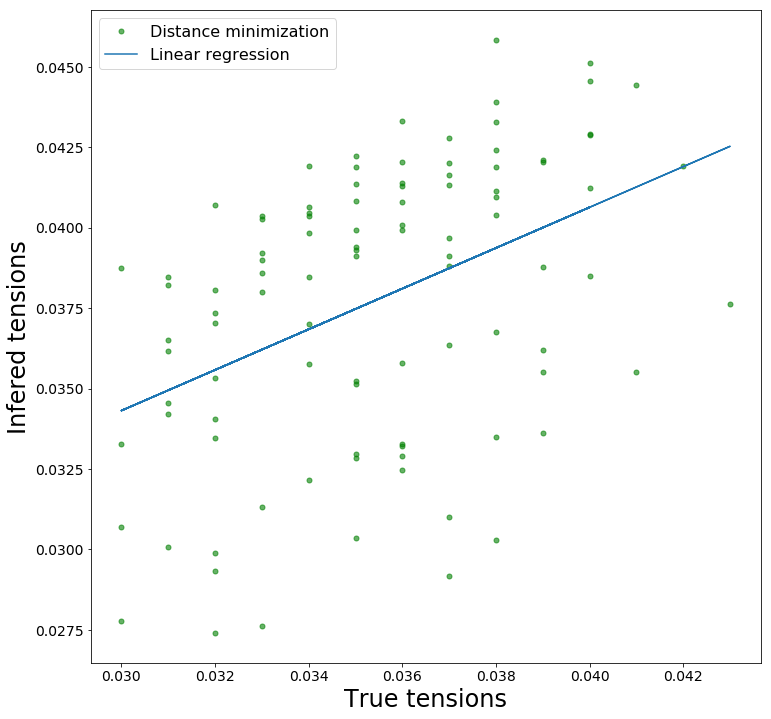

R value : 0.43280173296233404 
Standard error : 0.00198239025338738


In [13]:
from scipy import stats
x_data = organo.edge_df.line_tension[2*organo.Nf:3*organo.Nf]
y_data = rec_t[2*organo.Nf:3*organo.Nf]
title = ''
xlabel = 'True tensions'
ylabel = 'Infered tensions'
legend = ('Distance minimization', 'Linear regression')
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data,
                                                               y_data)
fig, ax = plt.subplots()
plt.plot(x_data, y_data, 'g.', markersize=10, alpha=0.6)
plt.plot(x_data, intercept+slope*np.array(x_data), '-')
plt.title(title, fontdict={'fontsize': 32})
plt.legend(legend, loc='upper left', fontsize=16)
plt.xlabel(xlabel, fontdict={'fontsize': 24})
plt.ylabel(ylabel, fontdict={'fontsize': 24})
fig.set_size_inches(12, 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
std = np.sum(np.power(intercept+slope*np.array(x_data)-y_data, 2))
print('R value :', r_value,
      '\nStandard error :', (std/organo.Ne)**0.5)

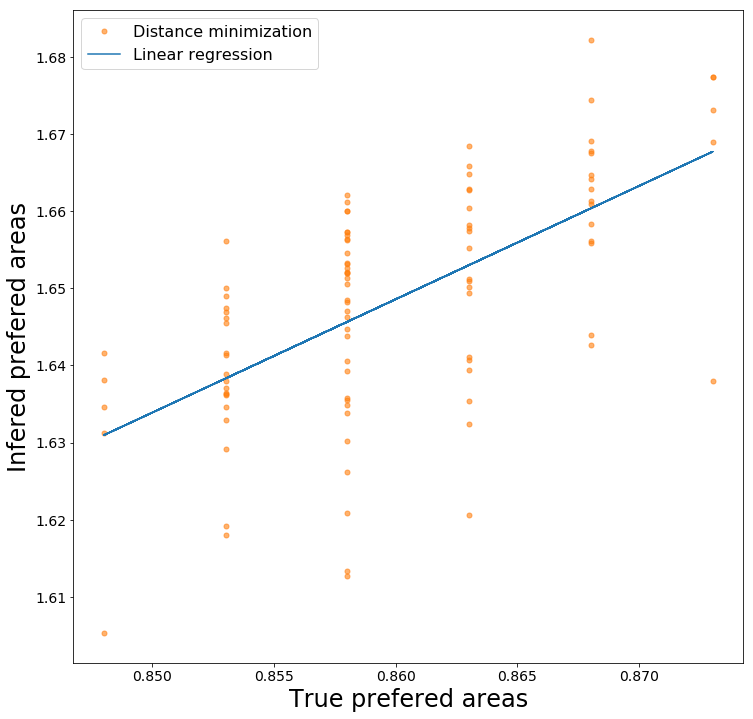

In [11]:
x_data = organo.face_df.prefered_area
y_data = rec_a[:-1]+organo.face_df.area
title = ''
xlabel = 'True prefered areas'
ylabel = 'Infered prefered areas'
legend = ('Distance minimization', 'Linear regression')
slope, intercept, r_value, p_value, std_err = stats.linregress(x_data,
                                                               y_data)
fig, ax = plt.subplots()
plt.plot(x_data, y_data, '.', markersize=10, alpha=0.6, color='tab:orange')
plt.plot(x_data, intercept+slope*np.array(x_data), '-')
plt.title(title, fontdict={'fontsize': 32})
plt.legend(legend, loc='upper left', fontsize=16)
plt.xlabel(xlabel, fontdict={'fontsize': 24})
plt.ylabel(ylabel, fontdict={'fontsize': 24})
fig.set_size_inches(12, 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
std = np.sum(np.power(intercept+slope*np.array(x_data)-y_data, 2))